Memory-based model: based on Items <br>
Referrenc: https://towardsdatascience.com/how-to-build-a-simple-recommender-system-in-python-375093c3fb7d <br>

In [22]:
import os
import yaml
import dask.dataframe as dd
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
%matplotlib inline

In [11]:
ratings_df = pd.read_csv('ratings.csv')
ratings_df.head(4)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815


In [12]:
movies_df = pd.read_csv('movies.csv')
movies_df.head(3)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


In [13]:
df = pd.merge(ratings_df,movies_df,on='movieId')
df.head(3)

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [14]:
df.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


In [54]:
ratings = pd.DataFrame(df.groupby('movieId')['rating'].mean())
ratings.head()

,rating
movieId,
1,3.920930
2,3.431818
3,3.259615
4,2.357143
5,3.071429


In [55]:
ratings['number_of_ratings'] = df.groupby('movieId')['rating'].count()
ratings.head(4)

,rating,number_of_ratings
movieId,,
1,3.920930,215
2,3.431818,110
3,3.259615,52
4,2.357143,7


Text(0.5, 1.0, 'Distribution of ratings')

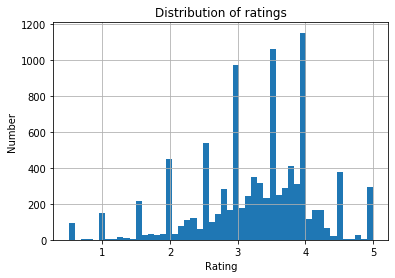

In [20]:
##1. plot a Histogram
ratings['rating'].hist(bins=50)
plt.xlabel('Rating')
plt.ylabel('Number')
plt.title('Distribution of ratings')

Text(0.5, 1.0, 'Distribution of number of ratings')

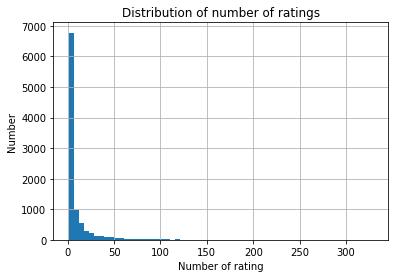

In [21]:
## 1.1 Visualize number of ratings
ratings['number_of_ratings'].hist(bins=60)
plt.xlabel('Number of rating')
plt.ylabel('Number')
plt.title('Distribution of number of ratings')

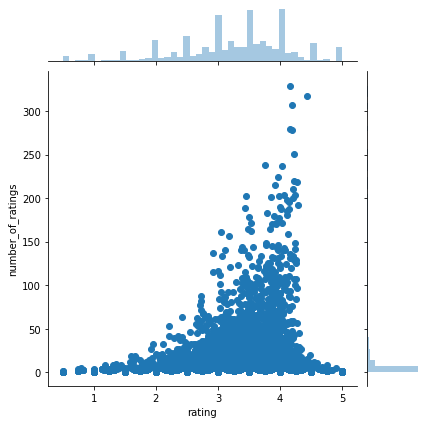

In [24]:
## 1.2 Check the relationship between ratings and number of ratings
sns.jointplot(x='rating',y='number_of_ratings',data = ratings)

In [25]:
## 2. Item-based recommendation system
# 建立一个矩阵：行（movie_id） 列（user_id） 值（rating）
# 计算correlation
movie_matrix = df.pivot_table(index = 'userId',columns='movieId',values = 'rating')
movie_matrix.head(3)

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
ratings.sort_values('number_of_ratings',ascending=False).head(3)

,rating,number_of_ratings
movieId,,
356,4.164134,329
318,4.429022,317
296,4.197068,307


In [33]:
# recommend movies to users based on watching history
# by computing correlation between movies
AFO_user_rating = movie_matrix[356]   # 对AFO电影打分的users情况
contact_user_rating = movie_matrix[318]

In [36]:
AFO_user_rating.head(3)

userId
1    4.0
2    NaN
3    NaN
Name: 356, dtype: float64

In [37]:
contact_user_rating.head(3)

userId
1    NaN
2    3.0
3    NaN
Name: 318, dtype: float64

In [43]:
# user "corwith" function compute correlation between 2 dataframes
similar_to_AFO = movie_matrix.corrwith(AFO_user_rating)
similar_to_AFO.head()

movieId
1    0.303465
2    0.367247
3    0.534682
4    0.388514
5    0.349541
dtype: float64

In [44]:
similar_to_contact = movie_matrix.corrwith(contact_user_rating)
similar_to_contact.head()

movieId
1    0.174984
2    0.097461
3    0.466380
4    0.644380
5    0.138314
dtype: float64

In [69]:
## drop NAN values
#corr_contact = pd.DataFrame(similar_to_contact,columns=['Correlation']).sort_values(by=['Correlation'],ascending=False)
corr_contact = pd.DataFrame(similar_to_contact,columns=['Correlation'])
corr_contact.dropna(inplace = True)
corr_contact.head()
corr_contact = corr_contact.join(ratings['number_of_ratings'])

In [70]:
corr_AFO = pd.DataFrame(similar_to_AFO,columns=['Correlation'])
corr_AFO.dropna(inplace=True)
#corr_AFO.head()
## 过滤一些number_of_ratings过少的条目
corr_AFO = corr_AFO.join(ratings['number_of_ratings'])

In [72]:
corr_AFO.head(3)
corr_contact.head(3)

,Correlation,number_of_ratings
movieId,,
1,0.174984,215
2,0.097461,110
3,0.466380,52


In [76]:
## 过滤
threshold = 100
K = 10
corr_AFO[corr_AFO['number_of_ratings'] > threshold].sort_values(by='Correlation',\
                                        ascending = False).head(K)
corr_contact[corr_contact['number_of_ratings'] > threshold].sort_values(by='Correlation',\
                                        ascending = False).head(K)

,Correlation,number_of_ratings
movieId,,
318,1.000000,317
357,0.446212,103
527,0.402202,220
50,0.394294,204
4963,0.391546,119
3147,0.382818,111
79132,0.377839,143
5989,0.356612,115
1193,0.354215,133
